## Task 2

The libraries used in task 2 are:
- **pandas:** Used in 2 ways: As a DB (hold and query data), and for graph generation
- **nltk:** Used to tokenize data
- **re:** Used to substitute text that matches a regular expression

Of note is that we abuse that only substituted expressions (URL, NUM etc.) have upper case letters. This allows us to discriminate the appropriate tokens to pre- and postfix
with brackets.

In [343]:
import numpy as np
import pandas as pd
import nltk
import re

import requests
from bs4 import BeautifulSoup as bs


In [344]:
df_load = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", delimiter=",")

In [345]:
df = df_load.copy()

def clean_text(txt):
  txt = txt.lower()
  txt = re.sub(r"\s+", " ", txt)
  regex = {"DATE" : r"(\d+[\\/-])?\d+[\\/-]\d+",
      "EMAIL" : r"\w+@\w+\.[a-z]{2,}",
      "URL" : r"([a-z\d]+://)?[a-z]+[a-z\d]*(\.[a-z\d\-\._~]+)+(/[a-z\d\-\._~]*|(\?[a-z\d\-\._~]+=[a-z\d\-\._~]+))*",
      "NUM" : r"[+-]?((\d+(,|\.))*\d+)"}
  for k in regex.keys():
    txt = re.sub(regex[k], k, txt) 
  return txt

def tokenize(txt):
  tokens = nltk.word_tokenize(txt)
  prepostfix = lambda t: "<"+t+">" if t.isupper() else t
  return list(map(prepostfix, tokens))

In [346]:
df = df.dropna(subset =["type"])

df_content = df["content"]
df_cleaned = df_content.apply(clean_text)
df_token = df_cleaned.apply(tokenize)

df["tokens"] = df_token

## Task 3 

We have made 4 observation on the dataset. Our 4th observation is least visually interesting, but may be the most informative when it comes to building a fake-news model from the dataset.

1. **Length by article type (*type_token_relation*):** 
This boxplot gives the distribution of the length of the articles in tokens within article types. Taking into consideration that the supermajority of articles types are undersamples in the data set (<6) (observation 2) this observation does not make it seem likely that there is a useful correlation between length and type.  
2. **URL token frequency by article type (*type_URLfreq_relation*):**
This boxplot gives the distribution of the frequency of the URL token within article type. It shows that many types are undersampled. This motivated us to look at the criteria for the types in the FakeNewsCorpus; aritcle types are mutually exclusive, but their semantics are not. This begs the question how FakeNews corpus decides when multiple types are appropriate - it seems that they have som rank-order for which type takes precedens, though as observation 4 shows this cannot be concluded.  
3. **Distribution of types (*type_distribution*):**
This barplot shows the distribution of types. From it we can conclude that the data(sub)set has an exponential drop-off in how populated each types is. Since we only have about 250 articles this means that the less populated types are very undersampled.
4. **Distribution of types within a domain(*domain_type_relation*)**
Most interestingly this oberservation shows us that each domain only have one type associated with them. This means that we have to be careful about what our model is actually checking; it could be that it is only checking the domain (through inference by the structure of the tokens) and then guesses by the type associated with the domain. It also shows that the datasubset have very few articles associated for each domain (<3).

In [347]:
# Function which returns list of token counts [URL, NUM, DATA, EMAIL, ALL_tokens]
def count_tokens(tokens):
    meta_tokens  = ["<URL>", "<NUM>", "<DATE>", "<EMAIL>"]
    meta_counts = [0, 0, 0, 0]
    for token in tokens:
      if token in meta_tokens:
        i = meta_tokens.index(token)
        meta_counts[i] += 1
    token_count = len(tokens)
    return [token_count] + meta_counts


# Observation 1 - relationship between type and tokencount (length of article)
def type_token_relation(df):
    counts = df["tokens"].apply(count_tokens)
    tokens = counts.apply(lambda xs: xs[0])
    tokens = tokens.rename("token_count")
    df_temp = pd.concat([df["type"], tokens], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["token_count"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 2 - relationship between type and URL frequency
def type_URLfreq_relation(df):
    counts = df["tokens"].apply(count_tokens)
    url_freq = counts.apply(lambda xs: xs[1]/xs[0])
    url_freq = url_freq.rename("url_freq")
    df_temp = pd.concat([df["type"], url_freq], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["url_freq"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 3 - type distribution of dataset
def type_distribution(df):
    df['type'].value_counts().plot.bar()
    return df['type'].value_counts()

# Observation 4 - types of article each domain publishes
def domain_type_relation(df):
    domains = df["domain"].unique()
    types = []
    for domain in domains:
        types.append(df[df["domain"] == domain]["type"].value_counts().to_dict())
    idx = sorted(range(len(types)), key=lambda i: list(types[i].items())[0][1])
    return list(map(lambda i: (domains[i], types[i]), reversed(idx)))

unreliable     361.666667
fake           769.554839
clickbait      329.000000
conspiracy     938.225806
reliable       530.666667
bias           520.833333
hate            67.000000
junksci        415.000000
political      756.086957
unknown       2730.000000
dtype: float64

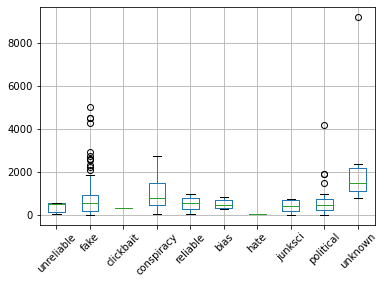

In [ ]:
type_token_relation(df)

unreliable    0.007411
fake          0.004505
clickbait     0.000000
conspiracy    0.003574
reliable      0.001008
bias          0.005705
hate          0.000000
junksci       0.013840
political     0.002906
unknown       0.001769
dtype: float64

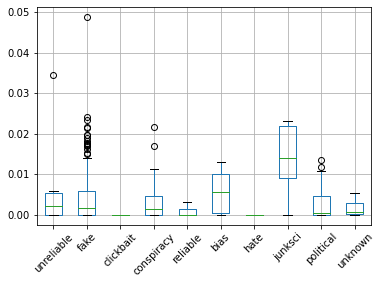

In [ ]:
type_URLfreq_relation(df)

fake          155
conspiracy     31
political      23
bias            6
unreliable      6
unknown         6
junksci         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

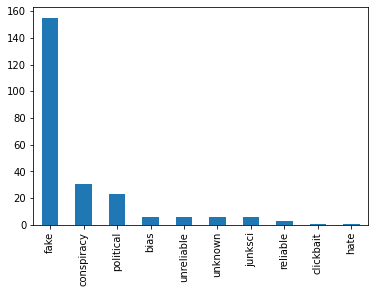

In [ ]:
type_distribution(df)

In [ ]:
domain_type_relation(df)

[('beforeitsnews.com', {'fake': 155}),
 ('canadafreepress.com', {'conspiracy': 24}),
 ('washingtonexaminer.com', {'political': 17}),
 ('awarenessact.com', {'conspiracy': 6}),
 ('naturalnews.com', {'junksci': 5}),
 ('strategic-culture.org', {'unknown': 4}),
 ('christianpost.com', {'reliable': 3}),
 ('city-journal.org', {'political': 2}),
 ('vdare.com', {'bias': 2}),
 ('undergroundhealth.com', {'unknown': 2}),
 ('alternet.org', {'political': 2}),
 ('awm.com', {'unreliable': 2}),
 ('breitbart.com', {'political': 1}),
 ('anonhq.com', {'unreliable': 1}),
 ('americanlookout.com', {'bias': 1}),
 ('washingtonsblog.com', {'bias': 1}),
 ('21stcenturywire.com', {'conspiracy': 1}),
 ('unz.com', {'bias': 1}),
 ('nationalreview.com', {'political': 1}),
 ('collectivelyconscious.net', {'junksci': 1}),
 ('breakpoint.org', {'unreliable': 1}),
 ('barenakedislam.com', {'hate': 1}),
 ('charismanews.com', {'bias': 1}),
 ('blackagendareport.com', {'unreliable': 1}),
 ('bipartisanreport.com', {'clickbait': 1}

# Task 4

The libraries used in task 4 are:
- **requests:** Used to send the HTTP requests and fetch the web page content.
- **BeautifulSoup:** Used to scrape information from web pages, and helps in extracting the data from HTML files.



In [365]:
def create_soup(url):
    site = requests.get(url)
    return bs(site.text, "html.parser")

soup = create_soup('https://en.wikinews.org/wiki/Category:Politics_and_conflicts')

letters = "ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[21%23:21%23+10]

In [368]:
def valid_links(soup):
    links=[]
    def is_valid(tag):
        return tag.name == 'a' and tag.get('title')[0] in letters
    section = {'id':"mw-pages"}
    subsection = {'class':"mw-category mw-category-columns"}
    for link in soup.find('div', section).find('div', subsection).find_all(is_valid):
        links.append("https://en.wikinews.org" + link.get('href'))
    return links

def next_page_url(soup):
    return "https://en.wikinews.org" + soup.find('a', string="next page").get('href')
    
def no_more_pages(soup):
    return soup.find('a', string="next page") is None

def get_links(soup, links):
    if no_more_pages(soup):
        return links
    else:
        links += valid_links(soup)
        next_soup = create_soup(next_page_url(soup))
        return get_links(next_soup, links)

In [370]:
links = get_links(soup, [])
len(links)

3039

In [435]:
def scrape(url):
    soup = create_soup(url)
    title = soup.find('h1', {'id':"firstHeading"}).text
    attr1 = {'id':"bodyContent"}
    attr2 = {'class':"mw-parser-output"}
    content = ""
    for tag in soup.find('div', attr1).find('div', attr2).find_all('p'):
        if tag.text.startswith('Have an opinion on this story'):
            break
        else:
            content += tag.text
    date, content = re.split(r"\n|\xa0",content, maxsplit=1)
    return title, date, content


scraped_data = pd.DataFrame(map(scrape, links), columns = ['title', 'date', 'content'])

In [433]:
dataframe2

,title,date,content
0,A 1-year long strike against FMC Novamed: Wome...,"Monday, September 17, 2007","\nIn a free trade zone in Antalya, Turkey, 80 ..."
1,A policeman is killed and another one is tortu...,"Wednesday, February 16, 2005","\nOn Sunday, February 6, 2005 the police offic..."
2,"A timeline: Novak, Rove, Cooper","Friday, July 15, 2005",\nThe Novak story that sparked the contoversy ...
3,Abbas and Olmert meet before Bush visit,"Tuesday, January 8, 2008",\nIsraeli Prime Minister Ehud Olmert and Pales...
4,Abbas fires security chiefs for failure to cur...,"Saturday, April 2, 2005",Palestinian Authority chairman Mahmoud Abbas f...
...,...,...,...
95,Airbnb announces intent to remove Israeli West...,"Thursday, November 22, 2018","On Monday, online rental firm Airbnb announced..."
96,Airline bombing suspect spent months in Yemen,"Wednesday, December 30, 2009",\nAuthorities in Yemen say the Nigerian man ac...
97,Airport named after late Nigerian President Um...,"Thursday, May 13, 2010",\nNigeria has announced that an airport has be...
98,Akayev flees Kyrgyzstan as protesters seize co...,"Thursday, March 24, 2005","\nThousands of demonstrators, reportedly cheer..."
